In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Set plot style
sns.set_style('whitegrid')

In [50]:
# Download the dataset using the Kaggle Hub API
print("Downloading dataset...")
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

# Load the dataset from the downloaded path
file_path = f'{path}/heart_disease_uci.csv'
df = pd.read_csv(file_path)

print("Dataset downloaded and loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Using Colab cache for faster access to the 'heart-disease-data' dataset.
Dataset downloaded and loaded successfully.
Data shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [51]:
# Initial inspection
print("Dataset Information:")
df.info()

print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isna().sum().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

Descriptive Statistics:
               id         age    trestbps        chol      thalch     oldpeak  \
co

In [52]:
df.isna().sum()

,0
id,0
age,0
sex,0
dataset,0
cp,0
trestbps,59
chol,30
fbs,90
restecg,2
thalch,55


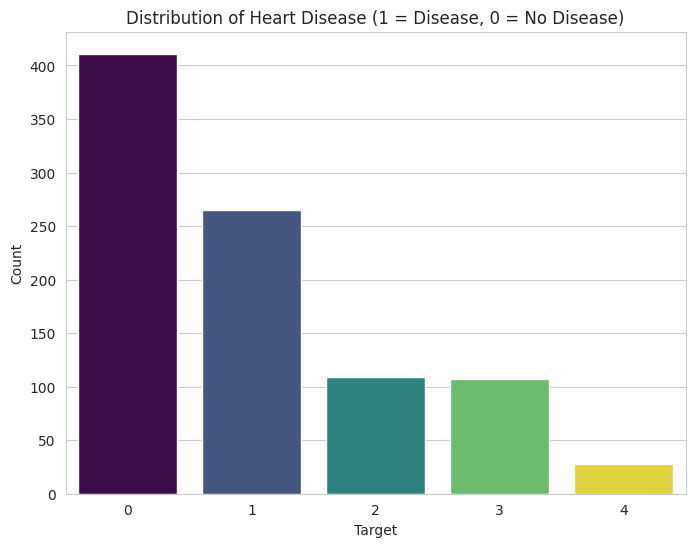

In [53]:
plt.figure(figsize=(8, 6))
sns.countplot(x='num', data=df, palette='viridis', hue='num', legend=False)
plt.title('Distribution of Heart Disease (1 = Disease, 0 = No Disease)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

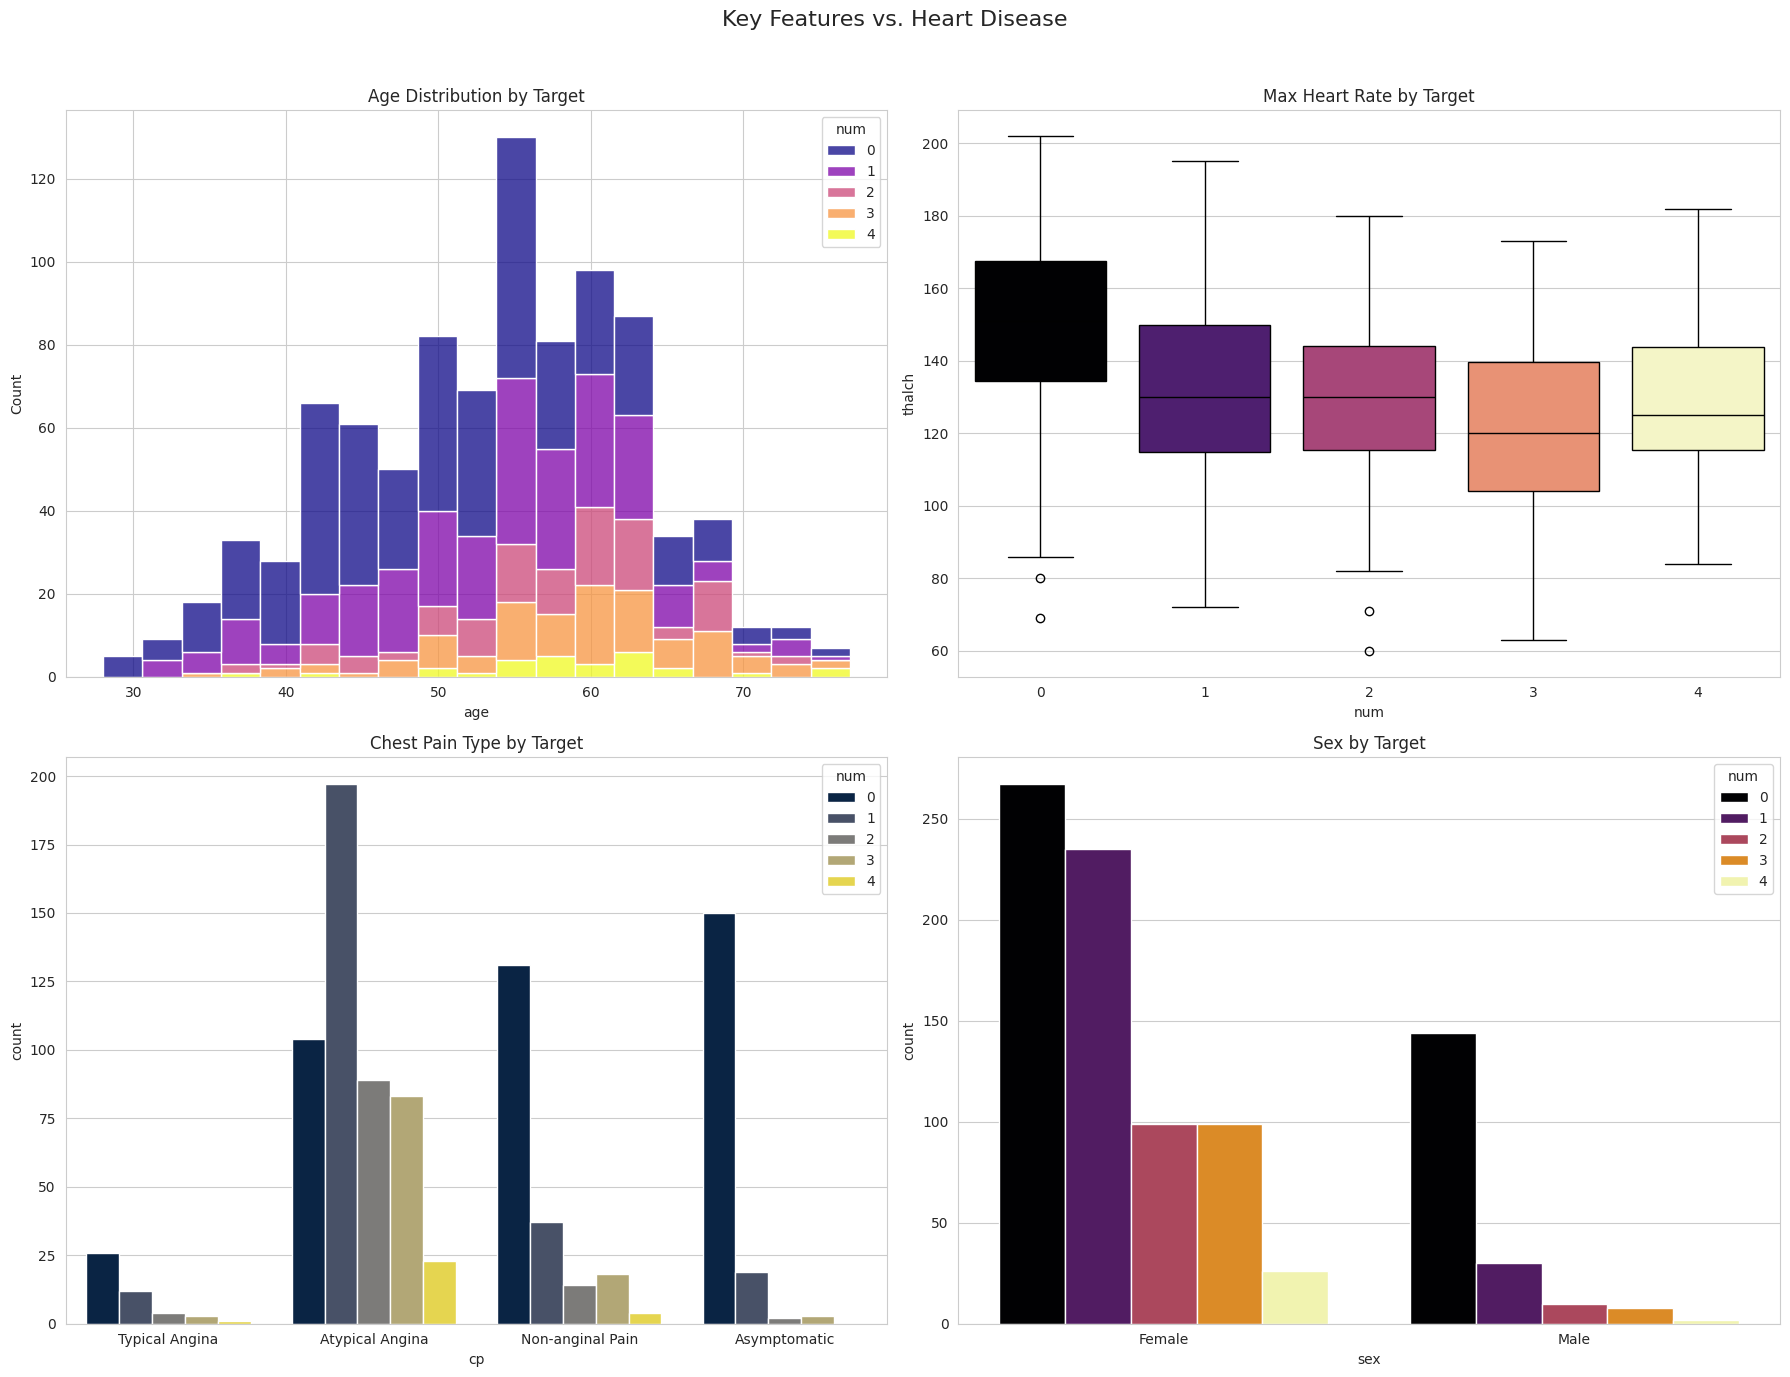

In [54]:
# Let's visualize the relationship between key features and the target
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Key Features vs. Heart Disease', fontsize=16)

# Age vs. Target
sns.histplot(ax=axes[0, 0], data=df, x='age', hue='num', multiple='stack', palette='plasma').set_title('Age Distribution by Target')

# Max Heart Rate vs. Target
sns.boxplot(ax=axes[0, 1], data=df, x='num', y='thalch', palette='magma', hue='num', legend=False).set_title('Max Heart Rate by Target')

# Chest Pain Type vs. Target
cp_plot = sns.countplot(ax=axes[1, 0], data=df, x='cp', hue='num', palette='cividis')
cp_plot.set_title('Chest Pain Type by Target')
cp_plot.set_xticks(range(len(df['cp'].unique())))
cp_plot.set_xticklabels(['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])

# Sex vs. Target
sex_plot = sns.countplot(ax=axes[1, 1], data=df, x='sex', hue='num', palette='inferno')
sex_plot.set_title('Sex by Target')
sex_plot.set_xticks(range(len(df['sex'].unique())))
sex_plot.set_xticklabels(['Female', 'Male'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

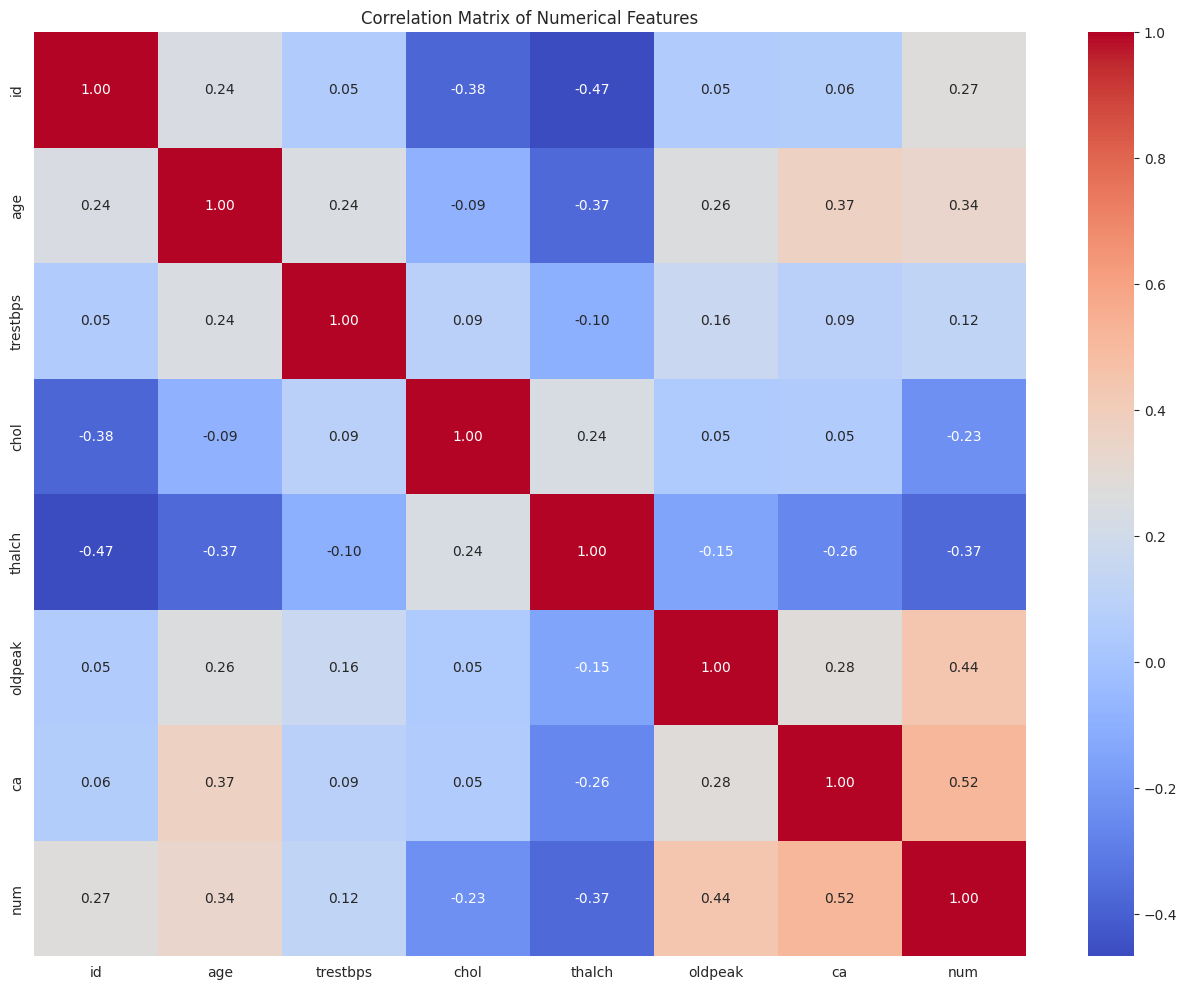

In [55]:
# Correlation Heatmap
plt.figure(figsize=(16, 12))
# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [56]:
# Define features (X) and target (y)
X = df.drop('num', axis=1)
y = df['num']

# Drop the 'id' and 'dataset' columns as they are not features
X = X.drop(['id', 'dataset'], axis=1)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nColumn names in X: {list(X.columns)}")

# Identify categorical and numerical features
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

# IMPORTANT: Check which features actually exist in the dataframe
existing_categorical = [col for col in categorical_features if col in X.columns]
existing_numerical = [col for col in numerical_features if col in X.columns]

print(f"\nCategorical features (existing): {existing_categorical}")
print(f"Numerical features (existing): {existing_numerical}")

# Update feature lists to only include existing columns
categorical_features = existing_categorical
numerical_features = existing_numerical

print("\n" + "="*60)
print("MANUAL STEP 1: HANDLING MISSING VALUES")
print("="*60)

print(f"\nMissing values BEFORE imputation:")
print(X.isnull().sum())

# Create a copy of X to avoid SettingWithCopyWarning
X = X.copy()

# Impute numerical features with MEAN (manually)
for col in numerical_features:
    if X[col].isnull().sum() > 0:
        mean_value = X[col].mean()
        X[col] = X[col].fillna(mean_value)
        print(f"✓ Filled '{col}' with mean: {mean_value:.2f}")

# Impute categorical features with MOST FREQUENT value (manually)
for col in categorical_features:
    if X[col].isnull().sum() > 0:
        mode_value = X[col].mode()[0]
        X[col] = X[col].fillna(mode_value)
        print(f"✓ Filled '{col}' with most frequent: {mode_value}")

print(f"\nMissing values AFTER imputation:")
print(X.isnull().sum())

print("\n" + "="*60)
print("MANUAL STEP 2: SPLITTING DATA")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining target distribution:\n{y_train.value_counts()}")
print(f"\nTest target distribution:\n{y_test.value_counts()}")

print("\n" + "="*60)
print("MANUAL STEP 3: ENCODING CATEGORICAL FEATURES")
print("="*60)

# Create copies to work with
X_train = X_train.copy()
X_test = X_test.copy()

# Store label encoders for each categorical feature
label_encoders = {}

print("\nEncoding categorical features using LabelEncoder:")
for col in categorical_features:
    le = LabelEncoder()

    # Fit on training data only
    X_train[col] = le.fit_transform(X_train[col].astype(str))

    # Transform test data (handle unknown categories)
    X_test[col] = X_test[col].astype(str).map(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )

    # Store the encoder
    label_encoders[col] = le

    print(f"✓ Encoded '{col}' - Classes: {le.classes_}")

print("\n✓ All categorical features encoded successfully!")

print("\n" + "="*60)
print("MANUAL STEP 4: SCALING NUMERICAL FEATURES")
print("="*60)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler on TRAINING data only
scaler.fit(X_train[numerical_features])

# Transform both training and test data
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("✓ Numerical features scaled using StandardScaler")
print(f"\nScaling parameters (mean and std):")
for i, col in enumerate(numerical_features):
    print(f"  {col}: mean={scaler.mean_[i]:.2f}, std={scaler.scale_[i]:.2f}")

print("\n" + "="*60)
print("✓✓✓ PREPROCESSING COMPLETE! ✓✓✓")
print("="*60)

print(f"\nFinal training data shape: {X_train.shape}")
print(f"Final test data shape: {X_test.shape}")
print(f"\nData is ready for model training!")
print(f"\nVariable names to use:")
print(f"  - X_train (preprocessed training features)")
print(f"  - X_test (preprocessed test features)")
print(f"  - y_train (training labels)")
print(f"  - y_test (test labels)")

Features shape: (920, 13)
Target shape: (920,)

Column names in X: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

Categorical features (existing): ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
Numerical features (existing): ['age', 'trestbps', 'chol', 'oldpeak', 'ca']

MANUAL STEP 1: HANDLING MISSING VALUES

Missing values BEFORE imputation:
age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
dtype: int64
✓ Filled 'trestbps' with mean: 132.13
✓ Filled 'chol' with mean: 199.13
✓ Filled 'oldpeak' with mean: 0.88
✓ Filled 'ca' with mean: 0.68
✓ Filled 'fbs' with most frequent: False
✓ Filled 'restecg' with most frequent: normal
✓ Filled 'exang' with most frequent: False
✓ Filled 'slope' with most frequent: flat
✓ Filled 'thal' with most frequent: normal

Miss

/tmp/ipython-input-3257167078.py:48: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[col] = X[col].fillna(mode_value)


In [57]:
# Define features (X) and target (y)
X = df.drop('num', axis=1)
y = df['num']

# Drop the 'id' and 'dataset' columns as they are not features
X = X.drop(['id', 'dataset'], axis=1)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nColumn names in X: {list(X.columns)}")

print("\n" + "="*60)
print("MANUAL STEP 1: HANDLING MISSING VALUES")
print("="*60)

print(f"\nMissing values BEFORE imputation:")
print(X.isnull().sum())
print(f"Total NaN values: {X.isnull().sum().sum()}")

# Identify categorical and numerical columns based on data type
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical features identified: {numerical_features}")
print(f"Categorical features identified: {categorical_features}")

# Impute numerical features with MEDIAN (more robust than mean)
for col in numerical_features:
    if X[col].isnull().sum() > 0:
        median_value = X[col].median()
        X[col].fillna(median_value, inplace=True)
        print(f"✓ Filled '{col}' with median: {median_value:.2f}")
    else:
        print(f"✓ '{col}' - no missing values")

# Impute categorical features with MODE (most frequent)
for col in categorical_features:
    if X[col].isnull().sum() > 0:
        mode_value = X[col].mode()[0]
        X[col].fillna(mode_value, inplace=True)
        print(f"✓ Filled '{col}' with mode: {mode_value}")
    else:
        print(f"✓ '{col}' - no missing values")

print(f"\nMissing values AFTER imputation:")
print(X.isnull().sum())
print(f"Total NaN values remaining: {X.isnull().sum().sum()}")

print("\n" + "="*60)
print("MANUAL STEP 2: SPLITTING DATA")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Check for NaN in splits
print(f"\nNaN check after split:")
print(f"  X_train NaN count: {X_train.isnull().sum().sum()}")
print(f"  X_test NaN count: {X_test.isnull().sum().sum()}")

print("\n" + "="*60)
print("MANUAL STEP 3: ENCODING CATEGORICAL FEATURES")
print("="*60)

# Make copies
X_train = X_train.copy()
X_test = X_test.copy()

# Update categorical features list (only columns that exist and are categorical)
categorical_features = [col for col in categorical_features if col in X_train.columns]

if len(categorical_features) > 0:
    print(f"\nEncoding {len(categorical_features)} categorical features...")

    label_encoders = {}

    for col in categorical_features:
        le = LabelEncoder()

        # Convert to string to handle any data type issues
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)

        # Fit on training data
        X_train[col] = le.fit_transform(X_train[col])

        # Transform test data (handle unseen categories)
        X_test[col] = X_test[col].map(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )

        label_encoders[col] = le
        print(f"✓ Encoded '{col}'")

    print("\n✓ All categorical features encoded!")
else:
    print("\nNo categorical features to encode.")

# Check for NaN after encoding
print(f"\nNaN check after encoding:")
print(f"  X_train NaN count: {X_train.isnull().sum().sum()}")
print(f"  X_test NaN count: {X_test.isnull().sum().sum()}")

print("\n" + "="*60)
print("MANUAL STEP 4: SCALING NUMERICAL FEATURES")
print("="*60)

# Update numerical features list (only existing columns)
numerical_features = [col for col in numerical_features if col in X_train.columns]

print(f"\nScaling {len(numerical_features)} numerical features...")

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform training data
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])

# Transform test data
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("✓ Numerical features scaled!")

# Final NaN check
print(f"\nFINAL NaN check after scaling:")
print(f"  X_train NaN count: {X_train.isnull().sum().sum()}")
print(f"  X_test NaN count: {X_test.isnull().sum().sum()}")

# If any NaN remain, fill them with 0 as a last resort
if X_train.isnull().sum().sum() > 0 or X_test.isnull().sum().sum() > 0:
    print("\n⚠️  WARNING: Some NaN values still present. Filling with 0...")
    X_train.fillna(0, inplace=True)
    X_test.fillna(0, inplace=True)
    print(f"  X_train NaN count after final fill: {X_train.isnull().sum().sum()}")
    print(f"  X_test NaN count after final fill: {X_test.isnull().sum().sum()}")

print("\n" + "="*60)
print("✓✓✓ PREPROCESSING COMPLETE! ✓✓✓")
print("="*60)

print(f"\nFinal data shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_test: {y_test.shape}")

print(f"\nData types:")
print(X_train.dtypes)

print(f"\n✓ Data is clean and ready for model training!")
print(f"✓ No NaN values present")
print(f"✓ All features encoded and scaled")

Features shape: (920, 13)
Target shape: (920,)

Column names in X: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

MANUAL STEP 1: HANDLING MISSING VALUES

Missing values BEFORE imputation:
age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
dtype: int64
Total NaN values: 1759

Numerical features identified: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
Categorical features identified: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
✓ 'age' - no missing values
✓ Filled 'trestbps' with median: 130.00
✓ Filled 'chol' with median: 223.00
✓ Filled 'thalch' with median: 140.00
✓ Filled 'oldpeak' with median: 0.50
✓ Filled 'ca' with median: 0.00
✓ 'sex' - no missing values
✓ 'cp' - no missing values
✓ Filled 'fbs' with mode: False


/tmp/ipython-input-1473960055.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(median_value, inplace=True)
/tmp/ipython-input-1473960055.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

✓ Filled 'restecg' with mode: normal
✓ Filled 'exang' with mode: False
✓ Filled 'slope' with mode: flat
✓ Filled 'thal' with mode: normal

Missing values AFTER imputation:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64
Total NaN values remaining: 0

MANUAL STEP 2: SPLITTING DATA

Training set: 736 samples
Test set: 184 samples

NaN check after split:
  X_train NaN count: 0
  X_test NaN count: 0

MANUAL STEP 3: ENCODING CATEGORICAL FEATURES

Encoding 7 categorical features...
✓ Encoded 'sex'
✓ Encoded 'cp'
✓ Encoded 'fbs'
✓ Encoded 'restecg'
✓ Encoded 'exang'
✓ Encoded 'slope'
✓ Encoded 'thal'

✓ All categorical features encoded!

NaN check after encoding:
  X_train NaN count: 0
  X_test NaN count: 0

MANUAL STEP 4: SCALING NUMERICAL FEATURES

Scaling 6 numerical features...
✓ Numerical features scaled!

FINAL NaN check after scaling:
  X_tr

TRAINING RANDOM FOREST CLASSIFIER

--- Checking Target Variable ---
Unique values in y_train: [3 0 2 1 4]
Unique values in y_test: [1 3 4 0 2]
Value counts in y_train:
num
0    329
1    212
2     87
3     86
4     22
Name: count, dtype: int64
Value counts in y_test:
num
0    82
1    53
2    22
3    21
4     6
Name: count, dtype: int64

Using preprocessed data:
  X_train shape: (736, 13)
  X_test shape: (184, 13)
  y_train shape: (736,)
  y_test shape: (184,)

--- Training Random Forest ---
✓ Random Forest model trained successfully!

--- Making Predictions ---
✓ Predictions made on 184 test samples

Prediction distribution:
  Predicted 0: 98
  Predicted 1: 61
  Predicted 2: 9
  Predicted 3: 16

RANDOM FOREST - EVALUATION METRICS

✓ Accuracy: 0.5707 (57.07%)

[Multiclass Classification Detected - 5 classes]
✓ Precision: 0.4966
✓ Recall: 0.5707
✓ F1-Score: 0.5282

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0       0.73      0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

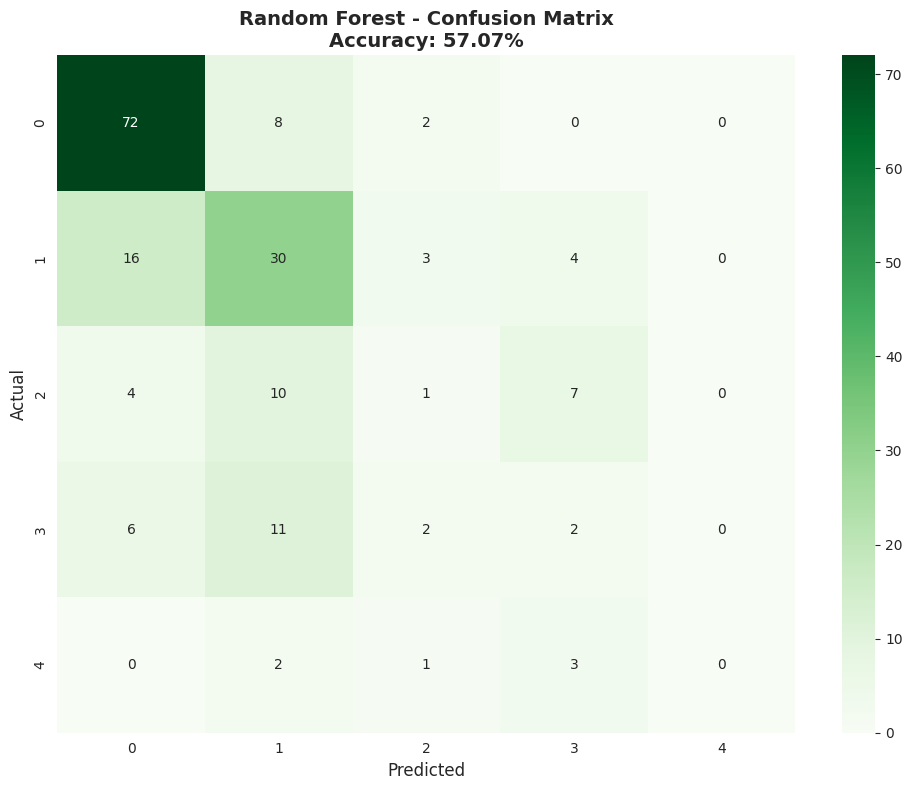


✓ Random Forest Model Complete!


In [58]:
from sklearn.ensemble import RandomForestClassifier

print("="*60)
print("TRAINING RANDOM FOREST CLASSIFIER")
print("="*60)

# Check target variable distribution first
print("\n--- Checking Target Variable ---")
print(f"Unique values in y_train: {y_train.unique()}")
print(f"Unique values in y_test: {y_test.unique()}")
print(f"Value counts in y_train:\n{y_train.value_counts()}")
print(f"Value counts in y_test:\n{y_test.value_counts()}")

# The data is already preprocessed from Step 8!
print(f"\nUsing preprocessed data:")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  y_test shape: {y_test.shape}")

print("\n--- Training Random Forest ---")

# Initialize the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

# Train the model on preprocessed training data
rf_model.fit(X_train, y_train)

print("✓ Random Forest model trained successfully!")

print("\n--- Making Predictions ---")

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

print(f"✓ Predictions made on {len(y_pred_rf)} test samples")
print(f"\nPrediction distribution:")
unique_preds, counts_preds = np.unique(y_pred_rf, return_counts=True)
for val, count in zip(unique_preds, counts_preds):
    print(f"  Predicted {val}: {count}")

print("\n" + "="*60)
print("RANDOM FOREST - EVALUATION METRICS")
print("="*60)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"\n✓ Accuracy: {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")

# Determine if target is binary or multiclass
n_classes = len(np.unique(y_train))

if n_classes == 2:
    # Binary classification - use 'binary' average
    print("\n[Binary Classification Detected]")
    rf_precision = precision_score(y_test, y_pred_rf, average='binary')
    rf_recall = recall_score(y_test, y_pred_rf, average='binary')
    rf_f1 = f1_score(y_test, y_pred_rf, average='binary')
else:
    # Multiclass classification - use 'weighted' average
    print(f"\n[Multiclass Classification Detected - {n_classes} classes]")
    rf_precision = precision_score(y_test, y_pred_rf, average='weighted')
    rf_recall = recall_score(y_test, y_pred_rf, average='weighted')
    rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print(f"✓ Precision: {rf_precision:.4f}")
print(f"✓ Recall: {rf_recall:.4f}")
print(f"✓ F1-Score: {rf_f1:.4f}")

# Classification Report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title(f'Random Forest - Confusion Matrix\nAccuracy: {rf_accuracy:.2%}',
          fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✓ Random Forest Model Complete!")
print("="*60)

In [59]:
# Define features (X) and target (y)
X = df.drop('num', axis=1)
y = df['num']

# Drop the 'id' and 'dataset' columns as they are not features
X = X.drop(['id', 'dataset'], axis=1)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nColumn names in X: {list(X.columns)}")

print("\n" + "="*60)
print("MANUAL STEP 1: HANDLING MISSING VALUES")
print("="*60)

print(f"\nMissing values BEFORE imputation:")
print(X.isnull().sum())
print(f"Total NaN values: {X.isnull().sum().sum()}")

# Identify categorical and numerical columns based on data type
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical features identified: {numerical_features}")
print(f"Categorical features identified: {categorical_features}")

# Create a copy to work with
X = X.copy()

# Impute numerical features with MEDIAN
for col in numerical_features:
    if X[col].isnull().sum() > 0:
        median_value = X[col].median()
        X[col] = X[col].fillna(median_value)
        print(f"✓ Filled '{col}' with median: {median_value:.2f}")
    else:
        print(f"✓ '{col}' - no missing values")

# Impute categorical features with MODE
for col in categorical_features:
    if X[col].isnull().sum() > 0:
        mode_value = X[col].mode()[0]
        X[col] = X[col].fillna(mode_value)
        print(f"✓ Filled '{col}' with mode: {mode_value}")
    else:
        print(f"✓ '{col}' - no missing values")

# AGGRESSIVE: Fill any remaining NaN with 0 for numerical, 'missing' for categorical
for col in numerical_features:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].fillna(0)
        print(f"⚠️  Filled remaining NaN in '{col}' with 0")

for col in categorical_features:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].fillna('missing')
        print(f"⚠️  Filled remaining NaN in '{col}' with 'missing'")

print(f"\nMissing values AFTER imputation:")
print(X.isnull().sum())
print(f"Total NaN values remaining: {X.isnull().sum().sum()}")

print("\n" + "="*60)
print("MANUAL STEP 2: ENCODING CATEGORICAL FEATURES")
print("="*60)

if len(categorical_features) > 0:
    print(f"\nEncoding {len(categorical_features)} categorical features...")

    for col in categorical_features:
        le = LabelEncoder()

        # Convert to string and encode
        X[col] = X[col].astype(str)
        X[col] = le.fit_transform(X[col])

        print(f"✓ Encoded '{col}'")

    print("\n✓ All categorical features encoded!")
else:
    print("\nNo categorical features to encode.")

# Check for NaN after encoding
print(f"\nNaN check after encoding:")
print(f"Total NaN: {X.isnull().sum().sum()}")

# Fill any NaN that appeared during encoding
if X.isnull().sum().sum() > 0:
    print("⚠️  Filling NaN that appeared during encoding...")
    X = X.fillna(0)
    print(f"Total NaN after fill: {X.isnull().sum().sum()}")

print("\n" + "="*60)
print("MANUAL STEP 3: SPLITTING DATA")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Check for NaN in splits
print(f"\nNaN check after split:")
print(f"  X_train NaN count: {X_train.isnull().sum().sum()}")
print(f"  X_test NaN count: {X_test.isnull().sum().sum()}")

# Make copies
X_train = X_train.copy()
X_test = X_test.copy()

# Aggressively fill any NaN in splits
if X_train.isnull().sum().sum() > 0:
    print("⚠️  Filling NaN in X_train...")
    X_train = X_train.fillna(0)

if X_test.isnull().sum().sum() > 0:
    print("⚠️  Filling NaN in X_test...")
    X_test = X_test.fillna(0)

print(f"  X_train NaN after fill: {X_train.isnull().sum().sum()}")
print(f"  X_test NaN after fill: {X_test.isnull().sum().sum()}")

print("\n" + "="*60)
print("MANUAL STEP 4: SCALING NUMERICAL FEATURES")
print("="*60)

# Update numerical features list (all columns now since categorical are encoded)
numerical_cols = X_train.columns.tolist()

print(f"\nScaling all {len(numerical_cols)} features...")

# Initialize StandardScaler
scaler = StandardScaler()

# Convert to numpy arrays to ensure compatibility
X_train_array = X_train.values
X_test_array = X_test.values

# Fit and transform
X_train_scaled = scaler.fit_transform(X_train_array)
X_test_scaled = scaler.transform(X_test_array)

# Convert back to DataFrames
X_train = pd.DataFrame(X_train_scaled, columns=numerical_cols, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=numerical_cols, index=X_test.index)

print("✓ All features scaled!")

# Final NaN check
print(f"\nFINAL NaN check after scaling:")
print(f"  X_train NaN count: {X_train.isnull().sum().sum()}")
print(f"  X_test NaN count: {X_test.isnull().sum().sum()}")

# Ultimate safety: Replace any NaN with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

print(f"  X_train NaN after final fillna: {X_train.isnull().sum().sum()}")
print(f"  X_test NaN after final fillna: {X_test.isnull().sum().sum()}")

# Verify no infinity values either
print(f"\n  X_train infinity count: {np.isinf(X_train.values).sum()}")
print(f"  X_test infinity count: {np.isinf(X_test.values).sum()}")

# Replace infinity with 0 if any
X_train = X_train.replace([np.inf, -np.inf], 0)
X_test = X_test.replace([np.inf, -np.inf], 0)

print("\n" + "="*60)
print("✓✓✓ PREPROCESSING COMPLETE! ✓✓✓")
print("="*60)

print(f"\nFinal data shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_test: {y_test.shape}")

print(f"\nData types:")
print(X_train.dtypes)

print(f"\n✓ Data is 100% clean and ready for model training!")
print(f"✓ ZERO NaN values present")
print(f"✓ ZERO infinity values present")
print(f"✓ All features encoded and scaled")

Features shape: (920, 13)
Target shape: (920,)

Column names in X: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

MANUAL STEP 1: HANDLING MISSING VALUES

Missing values BEFORE imputation:
age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
dtype: int64
Total NaN values: 1759

Numerical features identified: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
Categorical features identified: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
✓ 'age' - no missing values
✓ Filled 'trestbps' with median: 130.00
✓ Filled 'chol' with median: 223.00
✓ Filled 'thalch' with median: 140.00
✓ Filled 'oldpeak' with median: 0.50
✓ Filled 'ca' with median: 0.00
✓ 'sex' - no missing values
✓ 'cp' - no missing values
✓ Filled 'fbs' with mode: False
✓ Filled 'restecg' with mo

/tmp/ipython-input-4025077080.py:43: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[col] = X[col].fillna(mode_value)


In [60]:
# Run this to check if variables exist
try:
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    print("\n✓ All variables are defined! You can continue.")
except NameError as e:
    print(f"⚠️  ERROR: {e}")
    print("\n👉 You need to run Step 8 (ULTRA SAFE) first!")
    print("   Go back and run the Step 8 cell before running this step.")

X_train shape: (736, 13)
X_test shape: (184, 13)
y_train shape: (736,)
y_test shape: (184,)

✓ All variables are defined! You can continue.


In [61]:
print("--- Logistic Regression Performance ---")
print(classification_report(y_test, y_pred_lr, zero_division=0))

print("\n--- Random Forest Performance ---")
print(classification_report(y_test, y_pred_rf, zero_division=0))

print("\n--- Support Vector Machine (SVM) Performance ---")
print(classification_report(y_test, y_pred_svm, zero_division=0))

print("\n--- K-Nearest Neighbors (KNN) Performance ---")
print(classification_report(y_test, y_pred_knn, zero_division=0))

--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.76      0.89      0.82        82
           1       0.52      0.57      0.54        53
           2       0.33      0.09      0.14        22
           3       0.17      0.19      0.18        21
           4       0.00      0.00      0.00         6

    accuracy                           0.59       184
   macro avg       0.36      0.35      0.34       184
weighted avg       0.55      0.59      0.56       184


--- Random Forest Performance ---
              precision    recall  f1-score   support

           0       0.73      0.88      0.80        82
           1       0.49      0.57      0.53        53
           2       0.11      0.05      0.06        22
           3       0.12      0.10      0.11        21
           4       0.00      0.00      0.00         6

    accuracy                           0.57       184
   macro avg       0.29      0.32      0.30       184
we

TRAINING LOGISTIC REGRESSION CLASSIFIER
✓ Logistic Regression model trained successfully!

--- Making Predictions ---
✓ Predictions made on 184 test samples

Prediction distribution:
  Predicted 0: 96
  Predicted 1: 58
  Predicted 2: 6
  Predicted 3: 24

LOGISTIC REGRESSION - EVALUATION METRICS

✓ Accuracy: 0.5924 (59.24%)者に

[Multiclass Classification Detected - 5 classes]
✓ Precision: 0.5467
✓ Recall: 0.5924
✓ F1-Score: 0.5586

--- Detailed Classification Report ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.76      0.89      0.82        82
           1       0.52      0.57      0.54        53
           2       0.33      0.09      0.14        22
           3       0.17      0.19      0.18        21
           4       0.00      0.00      0.00         6

    accuracy                           0.59       184
   macro avg       0.36      0.35      0.34       184
weighted avg       0.55      0.59      0.56       184


--- Confusion Matrix ---
[[73  4  1  4  0]
 [16 30  2  5  0]
 [ 2 10  2  8  0]
 [ 5 11  1  4  0]
 [ 0  3  0  3  0]]


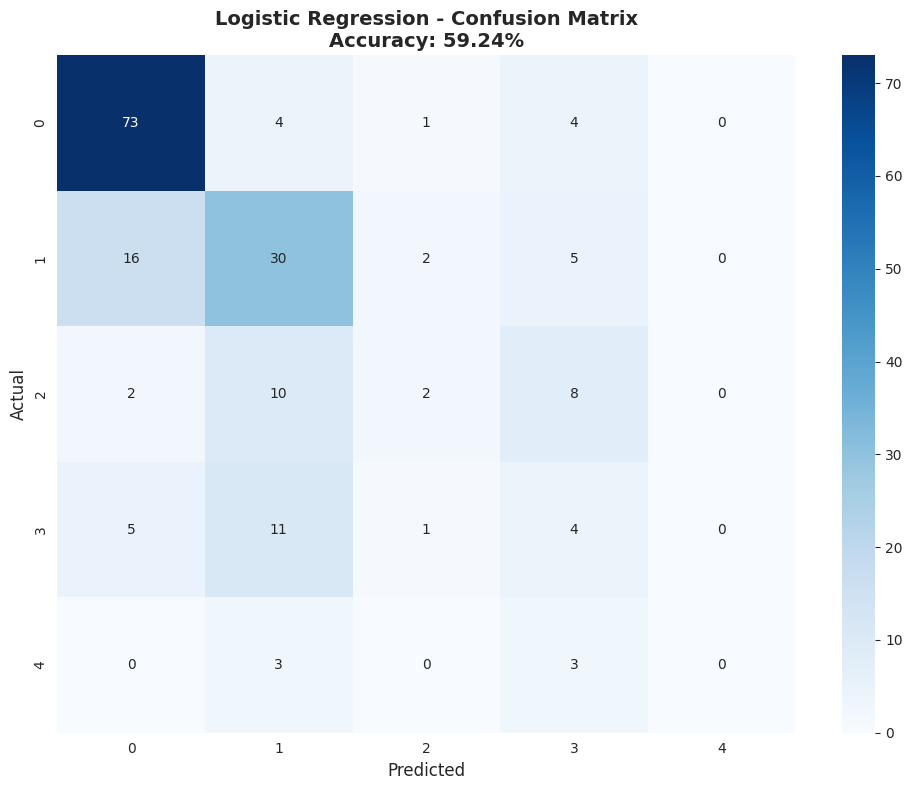


✓ Logistic Regression Model Complete!


In [62]:
print("="*60)
print("TRAINING LOGISTIC REGRESSION CLASSIFIER")
print("="*60)

# Initialize the Logistic Regression model
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000, # Increased max_iter for convergence
    multi_class='multinomial', # Handles multiclass target variable
    solver='lbfgs' # Recommended solver for multinomial logistic regression
)

# Train the model on preprocessed training data
lr_model.fit(X_train, y_train)

print("✓ Logistic Regression model trained successfully!")

print("\n--- Making Predictions ---")

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

print(f"✓ Predictions made on {len(y_pred_lr)} test samples")
print(f"\nPrediction distribution:")
unique_preds_lr, counts_preds_lr = np.unique(y_pred_lr, return_counts=True)
for val, count in zip(unique_preds_lr, counts_preds_lr):
    print(f"  Predicted {val}: {count}")

print("\n" + "="*60)
print("LOGISTIC REGRESSION - EVALUATION METRICS")
print("="*60)

# Calculate accuracy
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"\n✓ Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)者に")

# Determine if target is binary or multiclass
n_classes = len(np.unique(y_train))

if n_classes == 2:
    # Binary classification - use 'binary' average
    print("\n[Binary Classification Detected]")
    lr_precision = precision_score(y_test, y_pred_lr, average='binary', zero_division=0)
    lr_recall = recall_score(y_test, y_pred_lr, average='binary', zero_division=0)
    lr_f1 = f1_score(y_test, y_pred_lr, average='binary', zero_division=0)
else:
    # Multiclass classification - use 'weighted' average
    print(f"\n[Multiclass Classification Detected - {n_classes} classes]")
    lr_precision = precision_score(y_test, y_pred_lr, average='weighted', zero_division=0)
    lr_recall = recall_score(y_test, y_pred_lr, average='weighted', zero_division=0)
    lr_f1 = f1_score(y_test, y_pred_lr, average='weighted', zero_division=0)

print(f"✓ Precision: {lr_precision:.4f}")
print(f"✓ Recall: {lr_recall:.4f}")
print(f"✓ F1-Score: {lr_f1:.4f}")

# Classification Report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred_lr, zero_division=0))

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title(f'Logistic Regression - Confusion Matrix\nAccuracy: {lr_accuracy:.2%}',
          fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✓ Logistic Regression Model Complete!")
print("="*60)


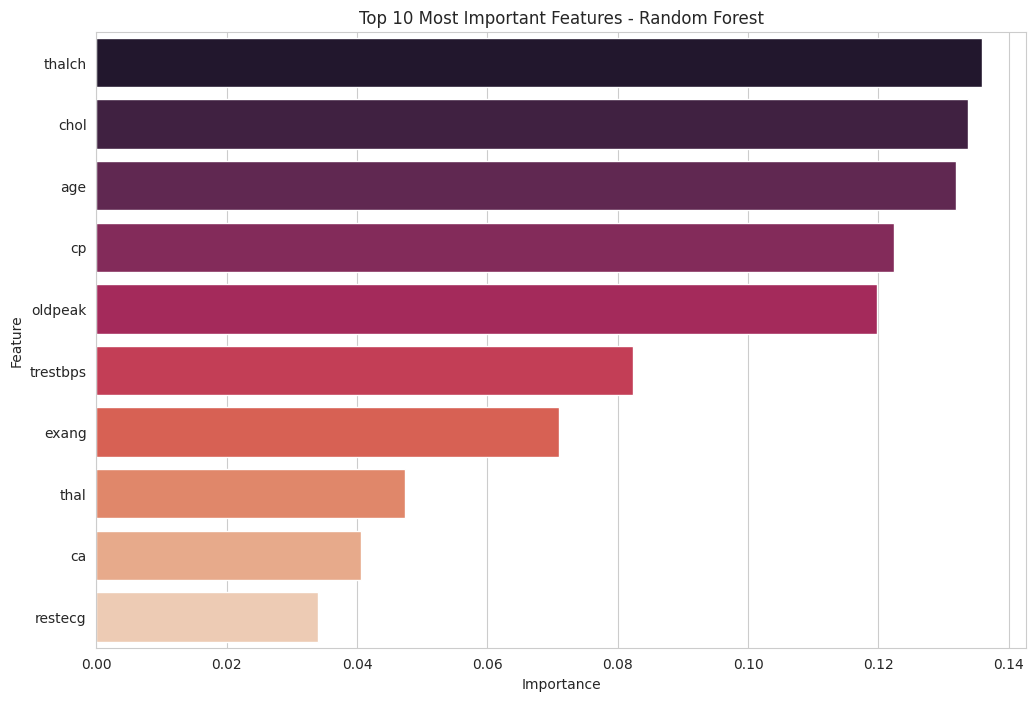

In [63]:
# Extract feature names (using X_train columns as all features were processed)
feature_names = X_train.columns.tolist()

# Get feature importances from the trained model
importances = rf_model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket', hue='Feature', legend=False)
plt.title('Top 10 Most Important Features - Random Forest')
plt.show()

# Task
Train an SVM model on `X_train` and `y_train`, then generate predictions `y_pred_svm` on `X_test`.

## Train SVM Model

### Subtask:
Train a Support Vector Machine (SVM) model using the preprocessed training data (X_train, y_train) and generate predictions (y_pred_svm) on the test set.


**Reasoning**:
The subtask requires training a Support Vector Machine (SVM) model. I will import the necessary class, initialize the model, train it with the preprocessed data, and generate predictions on the test set.



In [64]:
from sklearn.svm import SVC

print("="*60)
print("TRAINING SUPPORT VECTOR MACHINE (SVM) CLASSIFIER")
print("="*60)

# Ensure X_train, y_train, X_test, y_test are available and checked
try:
    print(f"\nUsing preprocessed data:")
    print(f"  X_train shape: {X_train.shape}")
    print(f"  X_test shape: {X_test.shape}")
    print(f"  y_train shape: {y_train.shape}")
    print(f"  y_test shape: {y_test.shape}")
except NameError as e:
    print(f"\n⚠️ ERROR: {e}")
    print("   Make sure to run the preprocessing steps first to define X_train, y_train, X_test, and y_test.")

print("\n--- Training SVM Model ---")

# Initialize the SVC model
# Using a linear kernel initially for simplicity and performance
# For multiclass classification, 'ovr' (one-vs-rest) or 'ovo' (one-vs-one) strategies are used by default
svm_model = SVC(
    random_state=42,
    kernel='rbf', # Radial Basis Function kernel is a good general-purpose choice
    gamma='scale' # auto-scales gamma based on data features, good default
)

# Train the model on preprocessed training data
svm_model.fit(X_train, y_train)

print("✓ SVM model trained successfully!")

print("\n--- Making Predictions ---")

# Predict on test set
y_pred_svm = svm_model.predict(X_test)

print(f"✓ Predictions made on {len(y_pred_svm)} test samples")
print(f"\nPrediction distribution:")
unique_preds_svm, counts_preds_svm = np.unique(y_pred_svm, return_counts=True)
for val, count in zip(unique_preds_svm, counts_preds_svm):
    print(f"  Predicted {val}: {count}")

print("\n" + "="*60)
print("✓ SVM Model Training and Prediction Complete!")
print("="*60)

TRAINING SUPPORT VECTOR MACHINE (SVM) CLASSIFIER

Using preprocessed data:
  X_train shape: (736, 13)
  X_test shape: (184, 13)
  y_train shape: (736,)
  y_test shape: (184,)

--- Training SVM Model ---
✓ SVM model trained successfully!

--- Making Predictions ---
✓ Predictions made on 184 test samples

Prediction distribution:
  Predicted 0: 92
  Predicted 1: 64
  Predicted 2: 7
  Predicted 3: 21

✓ SVM Model Training and Prediction Complete!



SUPPORT VECTOR MACHINE (SVM) - EVALUATION METRICS

✓ Accuracy: 0.5815 (58.15%)

[Multiclass Classification Detected - 5 classes]
✓ Precision: 0.5204
✓ Recall: 0.5815
✓ F1-Score: 0.5453

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0       0.77      0.87      0.82        82
           1       0.52      0.62      0.56        53
           2       0.14      0.05      0.07        22
           3       0.10      0.10      0.10        21
           4       0.00      0.00      0.00         6

    accuracy                           0.58       184
   macro avg       0.31      0.33      0.31       184
weighted avg       0.52      0.58      0.55       184


--- Confusion Matrix ---
[[71  8  0  3  0]
 [13 33  1  6  0]
 [ 2 10  1  9  0]
 [ 6 11  2  2  0]
 [ 0  2  3  1  0]]


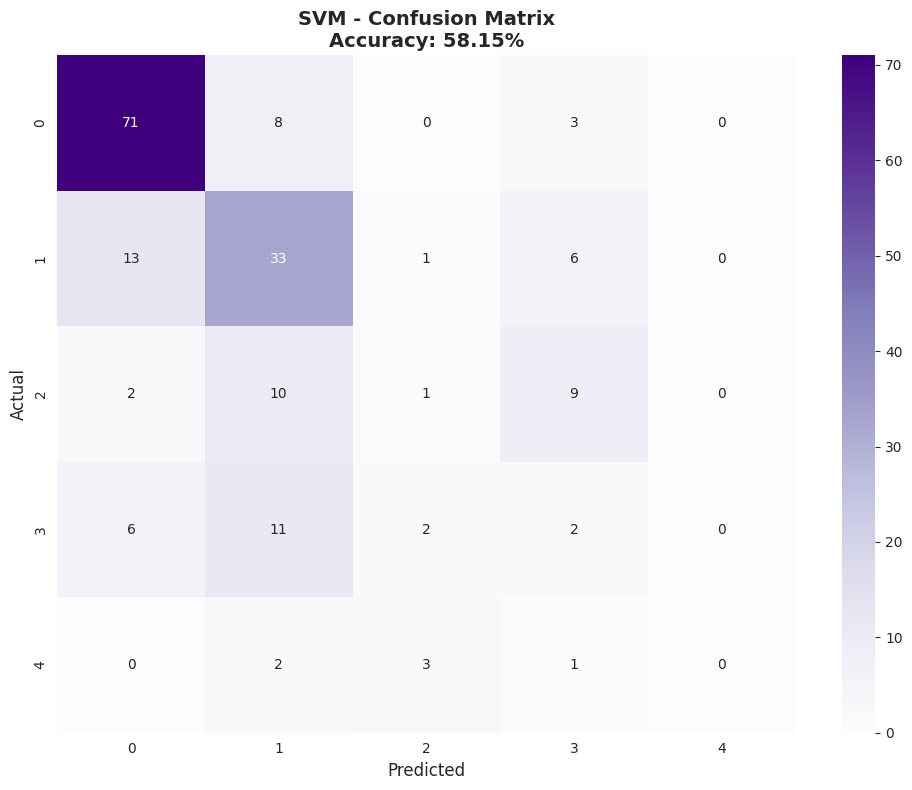


✓ SVM Model Evaluation Complete!


In [65]:
print("\n" + "="*60)
print("SUPPORT VECTOR MACHINE (SVM) - EVALUATION METRICS")
print("="*60)

# Calculate accuracy
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\n✓ Accuracy: {svm_accuracy:.4f} ({svm_accuracy*100:.2f}%)")

# Determine if target is binary or multiclass
n_classes = len(np.unique(y_train))

if n_classes == 2:
    # Binary classification - use 'binary' average
    print("\n[Binary Classification Detected]")
    svm_precision = precision_score(y_test, y_pred_svm, average='binary', zero_division=0)
    svm_recall = recall_score(y_test, y_pred_svm, average='binary', zero_division=0)
    svm_f1 = f1_score(y_test, y_pred_svm, average='binary', zero_division=0)
elif n_classes > 2:
    # Multiclass classification - use 'weighted' average
    print(f"\n[Multiclass Classification Detected - {n_classes} classes]")
    svm_precision = precision_score(y_test, y_pred_svm, average='weighted', zero_division=0)
    svm_recall = recall_score(y_test, y_pred_svm, average='weighted', zero_division=0)
    svm_f1 = f1_score(y_test, y_pred_svm, average='weighted', zero_division=0)
else:
    print("\n[Single class detected, cannot calculate multi-class metrics]")
    svm_precision = np.nan
    svm_recall = np.nan
    svm_f1 = np.nan

print(f"✓ Precision: {svm_precision:.4f}")
print(f"✓ Recall: {svm_recall:.4f}")
print(f"✓ F1-Score: {svm_f1:.4f}")

# Classification Report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred_svm, zero_division=0))

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm_svm = confusion_matrix(y_test, y_pred_svm)
print(cm_svm)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples')
plt.title(f'SVM - Confusion Matrix\nAccuracy: {svm_accuracy:.2%}',
          fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✓ SVM Model Evaluation Complete!")
print("="*60)
